Epoch 1, Loss: 0.64354407787323
Epoch 2, Loss: 0.6205267310142517
Epoch 3, Loss: 0.6183490753173828
Epoch 4, Loss: 0.619488537311554
Epoch 5, Loss: 0.6116228103637695
Epoch 6, Loss: 0.610643208026886
Epoch 7, Loss: 0.6033266186714172
Epoch 8, Loss: 0.6066295504570007
Epoch 9, Loss: 0.6239383816719055
Epoch 10, Loss: 0.6054192185401917


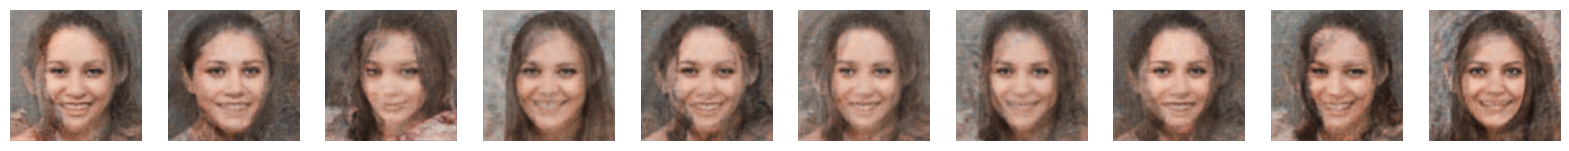

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os
from PIL import Image

# Load and preprocess the dataset
def load_images(image_dir, image_size=(256, 256)):
    images = []
    for filename in os.listdir(image_dir):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            img_path = os.path.join(image_dir, filename)
            img = Image.open(img_path).resize(image_size)
            img = np.array(img).astype('float32') / 255.0
            if img.shape == (image_size[0], image_size[1], 3):  # Ensure correct shape
                images.append(img)
    return np.array(images)

# Assuming you have your images in a directory called 'cat_images'
image_dir = 'fce/face'
x_train = load_images(image_dir)
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(buffer_size=1024).batch(16)

# Define encoder
def build_encoder(latent_dim):
    model = models.Sequential([
        layers.Input(shape=(256, 256, 3)),
        layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'),
        layers.Conv2D(64, 3, strides=2, padding='same', activation='relu'),
        layers.Conv2D(128, 3, strides=2, padding='same', activation='relu'),
        layers.Flatten(),
        layers.Dense(latent_dim * 2)  # Output mean and log variance
    ])
    return model

# Define sampling layer
class Sampling(layers.Layer):
    def call(self, inputs):
        mean, log_var = tf.split(inputs, num_or_size_splits=2, axis=1)
        epsilon = tf.random.normal(shape=tf.shape(mean))
        return mean + tf.exp(0.5 * log_var) * epsilon

# Define decoder
def build_decoder(latent_dim):
    model = models.Sequential([
        layers.Input(shape=(latent_dim,)),
        layers.Dense(32 * 32 * 128, activation='relu'),
        layers.Reshape((32, 32, 128)),
        layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu'),
        layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu'),
        layers.UpSampling2D((2,2)),
        layers.Conv2DTranspose(3, 3, padding='same', activation='sigmoid')  # Output layer for RGB images
    ])
    return model

# Define VAE model
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampling = Sampling()

    def call(self, inputs):
        mean, log_var = tf.split(self.encoder(inputs), num_or_size_splits=2, axis=1)
        z = self.sampling(tf.concat([mean, log_var], axis=1))
        return self.decoder(z), mean, log_var

    def compute_loss(self, x, x_reconstructed, mean, log_var):
        recon_loss = binary_crossentropy(x, x_reconstructed)
        recon_loss = tf.reduce_mean(recon_loss)
        kl_loss = -0.5 * tf.reduce_mean(log_var - tf.square(mean) - tf.exp(log_var) + 1)
        return recon_loss + kl_loss

# Parameters
latent_dim = 128  # Adjust as needed
epochs = 10

# Build and compile VAE
encoder = build_encoder(latent_dim)
encoder.summary
decoder = build_decoder(latent_dim)
vae = VAE(encoder, decoder)

optimizer = Adam()

@tf.function
def train_step(x):
    with tf.GradientTape() as tape:
        x_reconstructed, mean, log_var = vae(x)
        loss = vae.compute_loss(x, x_reconstructed, mean, log_var)
    grads = tape.gradient(loss, vae.trainable_variables)
    optimizer.apply_gradients(zip(grads, vae.trainable_variables))
    return loss

# Training loop
for epoch in range(epochs):
    for x_batch in train_dataset:
        loss = train_step(x_batch)
    print(f'Epoch {epoch+1}, Loss: {loss.numpy()}')

# Function to generate new data
def generate_new_data(vae, num_samples):
    z = tf.random.normal(shape=(num_samples, latent_dim))
    generated = vae.decoder(z)
    return generated.numpy()

# Generate and display some new images
generated_images = generate_new_data(vae, 10)
fig, axes = plt.subplots(1, 10, figsize=(20, 20))
for i, ax in enumerate(axes):
    ax.imshow(generated_images[i])
    ax.axis('off')
plt.show()
